<a href="https://colab.research.google.com/github/antaripg/machine-learning-notebooks/blob/main/BreastCancer_ML_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May 14 06:47:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%matplotlib inline

import numpy as np  #Matrix Calculations
import pandas as pd
import os
import math
import cv2
import scipy.ndimage
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
seed = 42
np.random.seed = seed

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
cols_names = ['Sample Code Number',             # 1- 10
              'Clump Thickness',                # 1- 10
              'Uniformity of Cell Size',        # 1- 10
              'Uniformity of Cell Shape',       # 1- 10
              'Marginal Adhesion',              # 1- 10
              'Single Epithelial Cell Size',    # 1- 10
              'Bare Nuclei',                    # 1- 10
              'Bland Chromatin',                # 1- 10
              'Normal Nucleoli',                # 1- 10
              'Mitoses',                        # 1- 10
              'Class']

In [ ]:
with open('/content/drive/MyDrive/BreastCancer_ML/breast_cancer_data.csv') as input_file:
    data_df = pd.read_csv(input_file,delimiter=',')

In [ ]:
data_df.head()

,Unnamed: 0,Sample Code Number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1000025,5,1,1,1,2,1,3,1,1,2
1,1,1002945,5,4,4,5,7,10,3,2,1,2
2,2,1015425,3,1,1,1,2,2,3,1,1,2
3,3,1016277,6,8,8,1,3,4,3,7,1,2
4,4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
data_df = data_df.dropna()
print(data_df.describe().T)
print(data_df.isnull().sum())

                             count          mean  ...        75%         max
Unnamed: 0                   699.0  3.490000e+02  ...      523.5       698.0
Sample Code Number           699.0  1.071704e+06  ...  1238298.0  13454352.0
Clump Thickness              699.0  4.417740e+00  ...        6.0        10.0
Uniformity of Cell Size      699.0  3.134478e+00  ...        5.0        10.0
Uniformity of Cell Shape     699.0  3.207439e+00  ...        5.0        10.0
Marginal Adhesion            699.0  2.806867e+00  ...        4.0        10.0
Single Epithelial Cell Size  699.0  3.216023e+00  ...        4.0        10.0
Bland Chromatin              699.0  3.437768e+00  ...        5.0        10.0
Normal Nucleoli              699.0  2.866953e+00  ...        4.0        10.0
Mitoses                      699.0  1.589413e+00  ...        1.0        10.0
Class                        699.0  2.689557e+00  ...        4.0         4.0

[11 rows x 8 columns]
Unnamed: 0                     0
Sample Code Number  

In [ ]:
data_df = data_df.rename (columns = {'Class':'Label'})
print(data_df.dtypes)

Unnamed: 0                      int64
Sample Code Number              int64
Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Label                           int64
dtype: object


In [ ]:
data_df['Label'].value_counts()

2    458
4    241
Name: Label, dtype: int64

In [ ]:
# # define X and normalizing values
# X = data_df.drop(labels = ['Label', 'Sample Code Number'], axis = 1)

In [ ]:
cols_final = ['Clump Thickness',                # 1- 10
              'Uniformity of Cell Size',        # 1- 10
              'Uniformity of Cell Shape',       # 1- 10
              'Marginal Adhesion',              # 1- 10
              'Single Epithelial Cell Size',    # 1- 10
              'Bare Nuclei',                    # 1- 10
              'Bland Chromatin',                # 1- 10
              'Normal Nucleoli',                # 1- 10
              'Mitoses']
df = data_df
check = '?'
for cols in cols_final:
  df[''+cols] = df[''+cols].replace('?',99999)

In [ ]:
df = df[~(df == 99999).any(axis='columns')]

In [ ]:
df['Label'].value_counts()


2    444
4    239
Name: Label, dtype: int64

In [ ]:
y = df['Label'].values

In [ ]:
labelencoder = LabelEncoder()
Y= labelencoder.fit_transform(y)

In [ ]:
Y.shape

(683,)

In [ ]:
X = df.drop(labels = ['Label', 'Sample Code Number'], axis = 1)

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
X.shape

(683, 10)

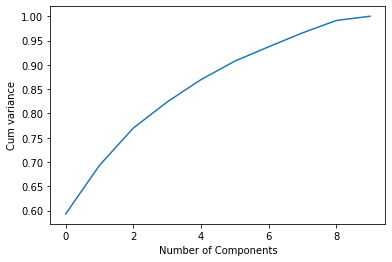

In [ ]:
# Performing PCA Analysis
from sklearn.decomposition import PCA

pca_test = PCA(n_components = 10)
pca_test.fit(X)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cum variance")
plt.show()

In [ ]:
# Let us pick n_components
n_PCA_components = 5
pca = PCA(n_components= n_PCA_components)
principalComponents = pca.fit_transform(X)

In [ ]:
PCA_df = pd.DataFrame( data = principalComponents,
                      columns = ['PC1', 'PC2','PC3','PC4','PC5'])

In [ ]:
PCA_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.324543,-1.799539,-0.464848,-0.445044,-0.065819
1,1.578718,-1.588472,-0.905972,0.378721,-0.534510
2,-1.447110,-1.804488,-0.432953,0.175309,-0.135507
3,1.613227,-1.387458,-0.812973,-0.498601,1.390107
4,-1.202042,-1.682549,-0.414981,0.134871,-0.371922


In [ ]:
print('Explained Variation per pricipal component: {}'.format(pca.explained_variance_ratio_))
print('Amount of information lost due to PCA: {}'.format(1 - np.sum(pca.explained_variance_ratio_)))

Explained Variation per pricipal component: [0.59320481 0.09996335 0.07671964 0.05372253 0.04593694]
Amount of information lost due to PCA: 0.13045272302110178


In [ ]:
df['Label']


0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: Label, Length: 683, dtype: int64

In [ ]:
final_df = pd.concat([PCA_df, data_df['Label']], axis = 1)

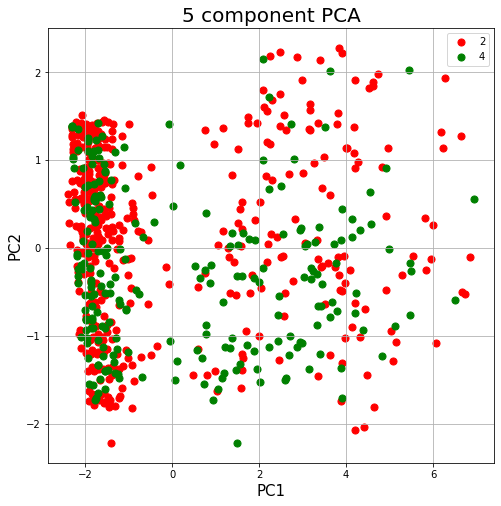

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('5 component PCA', fontsize = 20)
labels = [ 2, 4]
colors = ['r', 'g']
for label, color in zip(labels, colors):
  indicesToKeep = final_df['Label'] == label
  ax.scatter(final_df.loc[indicesToKeep, 'PC1'],
             final_df.loc[indicesToKeep, 'PC2'],
             c = color,
             s = 50)
ax.legend(labels)
ax.grid()

In [ ]:
X_PCA = final_df.drop(labels = ["Label"], axis = 1)

In [ ]:
y_PCA = final_df["Label"].values
labelencoder = LabelEncoder()
Y_PCA= labelencoder.fit_transform(y_PCA)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, Y_PCA, test_size = 0.25, random_state = 42 )

In [ ]:
# Creating a keras deep learning Sequential Model

model = Sequential()
model.add(Dense(16, input_dim = n_PCA_components, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss= 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import datetime
start = datetime.datetime.now()

history = model.fit(X_train, y_train, verbose = 1, epochs = 500 , batch_size = 64, shuffle = True, validation_split= 0.2)

end = datetime.datetime.now()

print("Total execution time - {}".format(end - start))


Epoch 1/500
7/7 [==============================] - 0s 15ms/step - loss: 0.6486 - accuracy: 0.6539 - val_loss: 0.6602 - val_accuracy: 0.6286
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 0.6486 - accuracy: 0.6539 - val_loss: 0.6602 - val_accuracy: 0.6286
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 0.6484 - accuracy: 0.6539 - val_loss: 0.6601 - val_accuracy: 0.6286
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 0.6483 - accuracy: 0.6539 - val_loss: 0.6601 - val_accuracy: 0.6286
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 0.6482 - accuracy: 0.6539 - val_loss: 0.6601 - val_accuracy: 0.6286
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 0.6481 - accuracy: 0.6539 - val_loss: 0.6600 - val_accuracy: 0.6286
Epoch 7/500
7/7 [==============================] - 0s 7ms/step - loss: 0.6480 - accuracy: 0.6539 - val_loss: 0.6600 - val_accuracy: 0.6286
Epoch 8/500
7/7 [=========

In [ ]:
_,acc = model.evaluate(X_test, y_test)
print('Accuracy = {} %'.format(acc *100))

6/6 [==============================] - 0s 2ms/step - loss: 0.6320 - accuracy: 0.6743
Accuracy = 67.42857098579407 %


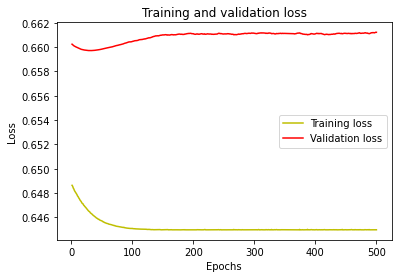

In [ ]:
#Plotting loss and accuracy plots

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

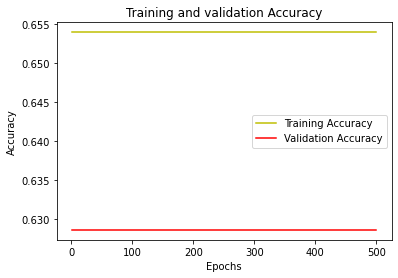

In [ ]:

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'r', label = 'Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()